In [1]:
import glob
import numpy as np
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.concat(pd.Series(glob.glob('/home/daniel/wizepair2/notebooks/elo/elo_input-*.csv.gz')).parallel_apply(pd.read_csv).tolist())

In [4]:
df.publication_date_greatest = pd.to_datetime(df.publication_date_greatest)
df.sort_values('publication_date_greatest', inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
df['label'] = df.standard_change=='increase'

In [6]:
df.head(3)

,wizepair2_uuid,assay_id,standard_type,standard_change,publication_date_greatest,fragment1,fragment2,radius,pref_name,chessleague_uuid,chessleague_partition,label
0,7cba99046eb3f9478deb4efd8d96dc13,954521,IC50,decrease,1970-01-01,07aea057e1d55a464d527ccccb3b2b5c,5abb3a61c31d85cee019df28914633fa,2,RT-4,78a43651d048795ddd77dfae9917c615,48,False
1,63589ff962863ae1344d44a0fe407e44,737382,EC50,decrease,1970-01-01,2e19831469f8b9aecf70e98d935cde55,2df97c488cd78b3fcf81b76ba11fe1aa,2,"Citrate synthase, peroxisomal",532d7d76eb210714c970532fa26062dd,60,False
2,ee2f9c37353dc62b597fd2103e2400e5,737382,EC50,increase,1970-01-01,42eb15a11af4ad03315b87cdc94273f3,fcd030edfdc7ce7e076622b846ed55c1,2,"Citrate synthase, peroxisomal",532d7d76eb210714c970532fa26062dd,60,True


In [7]:
df.publication_date_greatest.quantile([0, 0.05, 0.5, 0.95, 1])

0.00   1970-01-01
0.05   1989-02-02
0.50   2009-01-20
0.95   2018-09-13
1.00   2020-11-28
Name: publication_date_greatest, dtype: datetime64[ns]

In [8]:
len(df.index)

21787458

In [9]:
def elo(df, return_ratings=False):
    
    # create a table where winner / loser is defined
    if df.empty: return None
    
    # fit model
    model = EloEstimator(
        key1_field="fragment1",
        key2_field="fragment2",
        timestamp_field="publication_date_greatest",
        initial_time=pd.to_datetime('1970-01-01'),
        default_k=20
    ).fit(df, df.label)
    if return_ratings: return model.rating_model.to_frame()

    # calculate proba
    df['proba'] = model.transform(df, output_type='prob', strict_past_data=True)
    return df[['assay_id', 'wizepair2_uuid', 'chessleague_uuid', 'proba', 'label']]
    

In [10]:
df_elo = df.groupby(['chessleague_uuid']).parallel_apply(elo)

In [11]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    0.000002
0.1    0.472074
0.5    0.500000
0.9    0.527926
1.0    0.999998
Name: proba, dtype: float64

In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.570988993975907

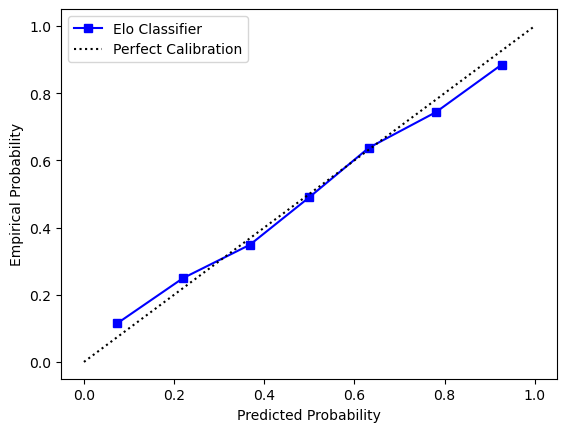

In [13]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=7
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [14]:
df_elo.sort_values('proba', ascending=False)

assay_id  \
chessleague_uuid                                      
6cd65b5fa27be3b2b0b8643f4b4adcd1 18623718   1552240   
                                 19755478   1685271   
                                 19396899   1652370   
                                 18902738   1563412   
                                 18519860   1925022   
...                                             ...   
                                 18518145   1925022   
                                 18898081   1563412   
                                 19396885   1652370   
                                 19755515   1685271   
                                 18624113   1552240   

                                                             wizepair2_uuid  \
chessleague_uuid                                                              
6cd65b5fa27be3b2b0b8643f4b4adcd1 18623718  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 19755478  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 19396899  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 18902738  660a5f32f3b87ff9eaac76d6ff98cf0b   
                                 18519860  660a5f32f3b87ff9eaac76d6ff98cf0b   
...                                                                     ...   
                                 18518145  fd0fe6b16e81218c3f233578a6056448   
                                 18898081  fd0fe6b16e81218c3f233578a6056448   
                                 19396885  fd0fe6b16e81218c3f233578a6056448   
                                 19755515  fd0fe6b16e81218c3f233578a6056448   
                                 18624113  fd0fe6b16e81218c3f233578a6056448   

                                                           chessleague_uuid  \
chessleague_uuid                                                              
6cd65b5fa27be3b2b0b8643f4b4adcd1 18623718  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 19755478  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 19396899  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 18902738  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 18519860  6cd65b5fa27be3b2b0b8643f4b4adcd1   
...                                                                     ...   
                                 18518145  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 18898081  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 19396885  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 19755515  6cd65b5fa27be3b2b0b8643f4b4adcd1   
                                 18624113  6cd65b5fa27be3b2b0b8643f4b4adcd1   

                                              proba  label  
chessleague_uuid                                            
6cd65b5fa27be3b2b0b8643f4b4adcd1 18623718  0.999998   True  
                                 19755478  0.999998   True  
                                 19396899  0.999998   True  
                                 18902738  0.999998   True  
                                 18519860  0.999998   True  
...                                             ...    ...  
                                 18518145  0.000002  False  
                                 18898081  0.000002  False  
                                 19396885  0.000002  False  
                                 19755515  0.000002  False  
                                 18624113  0.000002  False  

[21787458 rows x 5 columns]

In [15]:
df_ratings = df.groupby(['chessleague_uuid']).parallel_apply(elo, return_ratings=True)

In [16]:
df_ratings.sort_values('rating', ascending=False)

key  \
chessleague_uuid                                                            
936b2ab0848ce64836a1671bab454d8a 23327   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23326   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23325   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23324   7d10e7b4bb13ce25d0cb6302f324cb69   
                                 23323   7d10e7b4bb13ce25d0cb6302f324cb69   
...                                                                   ...   
bf8a7ae5540c33788794ebe2792c31d7 265036  21ea6a5665fb4674223ddbbb4487a64b   
                                 265035  21ea6a5665fb4674223ddbbb4487a64b   
                                 265038  21ea6a5665fb4674223ddbbb4487a64b   
                                 265037  21ea6a5665fb4674223ddbbb4487a64b   
                                 265039  21ea6a5665fb4674223ddbbb4487a64b   

                                              rating valid_from   valid_to  
chessleague_uuid                                                            
936b2ab0848ce64836a1671bab454d8a 23327   2664.786349 2016-03-11 2016-03-11  
                                 23326   2664.761534 2016-02-06 2016-03-11  
                                 23325   2663.261604 2016-02-06 2016-02-06  
                                 23324   2663.260300 2016-02-06 2016-02-06  
                                 23323   2657.030607 2016-02-06 2016-02-06  
...                                              ...        ...        ...  
bf8a7ae5540c33788794ebe2792c31d7 265036   110.000000 2019-03-28        NaT  
                                 265035   100.000000 2019-03-28 2019-03-28  
                                 265038   100.000000 2019-03-28        NaT  
                                 265037    90.000000 2019-03-28 2019-03-28  
                                 265039    80.000000 2019-03-28        NaT  

[48585555 rows x 4 columns]

In [17]:
df_ratings[df_ratings.valid_to.isna()].to_csv('/home/daniel/wizepair2/elo_ratings.csv.gz', compression='gzip')